# 1 Initialization of Environment
## Import of libraries and own DQN Agent

In [1]:
from unityagents import UnityEnvironment
from collections import deque
import numpy as np
import torch
from matplotlib import pyplot as plt

from dqn_agent import Agent

## Start of Unity Banana Environment and Initialization of DQN Agent

In [2]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

action_size = brain.vector_action_space_size
state_size = brain.vector_observation_space_size

agent = Agent(state_size=state_size, action_size=action_size, seed=0)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


# 2 Train the Agent by running Banana Collection Environment

In [3]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.990):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    score = 0
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        state = state["BananaBrain"].vector_observations
        for t in range(max_t):
            # get the next action
            action = agent.act(state, eps)
            # do the next action in the environment
            env_info = env.step(action)[brain_name]
            # get the resulting states from the environment
            next_state = env_info.vector_observations[0]
            # collect the reward from the last action
            reward = env_info.rewards[0]
            # check if our episode is done
            done = env_info.local_done[0]
            # feed our current observation back to the QNetwork
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score into the window of last 100 scores
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        if i_episode % 25 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=2000.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-25, np.mean(scores_window)))
            agent.save_checkpoint("simple_dqn.pth")
            break
    return scores

scores = dqn()

Episode 25	Average Score: 1.08
Episode 50	Average Score: 5.96
Episode 75	Average Score: 11.56
Episode 100	Average Score: 21.68
Episode 125	Average Score: 45.16
Episode 150	Average Score: 85.34
Episode 175	Average Score: 156.30
Episode 200	Average Score: 256.90
Episode 225	Average Score: 386.68
Episode 250	Average Score: 544.63
Episode 275	Average Score: 726.20
Episode 300	Average Score: 940.76
Episode 325	Average Score: 1189.69
Episode 350	Average Score: 1468.45
Episode 375	Average Score: 1760.30

Environment solved in 370 episodes!	Average Score: 2002.67


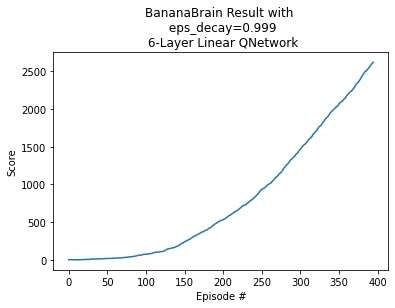

In [4]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title("BananaBrain Result with \n eps_decay=0.999\n 6-Layer Linear QNetwork")
plt.show()

# 3 Check trained Models

To check the four resulting models, I will give each model another hundred episodes to show the performance of each.
Moreover I want to check out, how big is the proportion of timesteps, where the Agent gets trapped inbetween two states.

In [3]:
from statistics import mean 

In [4]:
action_size = brain.vector_action_space_size
state_size = brain.vector_observation_space_size

In [5]:
def count_trapped_actions(action_list):
    """Count the length of agent movement where it get's trapped inbetween two states.
    Outputs the number of consecutively actions without any development.
    
    Params
    ======
        action_list (list): list of actions from one episode
    """
    repetition_count = 0
    element_list = []
    for el in reversed(action_list):
        element_list.append(el)
        if len(element_list) > 1:
            if len(set(element_list)) == 2:
                if element_list[-1] != element_list[-2]:
                    repetition_count += 1
                else:
                    break
            else:
                break
    return repetition_count

In [6]:
model_list = [
    ("simple_dqn_three_layers_0990.pth", "flat"),
    ("simple_dqn_three_layers_0999.pth", "flat"),
    ("simple_dqn_six_layers_0990.pth", "deep"),
    ("simple_dqn_six_layers_0999.pth", "deep")
]

for model_checkpoint in model_list:
    agent = Agent(state_size=state_size, action_size=action_size, seed=0, model=model_checkpoint[1])
    agent.load_checkpoint(model_checkpoint[0])
    mean_trapped_repetitions = []
    mean_scores = []

    for episode in range(100):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]            # get the current state
        score = 0                                          # initialize the score
        action_list = []
        while True:
            action = agent.act(state, 0.0)                 # select an action
            action_list.append(action)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        trapped_repetitions = count_trapped_actions(action_list)
        mean_trapped_repetitions.append(trapped_repetitions)
        mean_scores.append(score)
    # calculate the mean over the reward scores and the number of trapped repeations
    print(f"Model {model_checkpoint[0]}")
    print(f"Mean Trapped Actions: {mean(mean_trapped_repetitions)}")
    print(f"Mean Scores: {mean(mean_scores)}\n")

Model simple_dqn_three_layers_0990.pth
Mean Trapped Actions: 120.4
Mean Scores: 9.54

Model simple_dqn_three_layers_0999.pth
Mean Trapped Actions: 80.57
Mean Scores: 11.01

Model simple_dqn_six_layers_0990.pth
Mean Trapped Actions: 135.82
Mean Scores: 8.55

Model simple_dqn_six_layers_0999.pth
Mean Trapped Actions: 164.05
Mean Scores: 6.6



<div class="alert alert-block alert-danger">
We can see, that a deeper linear architecture is influencing the resulting Network in a very unfavorable way.
We can also see, that increasing the Epsilon Decay factor, which leads to more Exploration over Exploitation, will decrease the performance of the deeper architecture even more.</div>

<div class="alert alert-block alert-success">
The flat architector improves it's performance by increasing the Epsilon Decay Factor which seems plausible too me, as increased intensity of Exploration should decrease the chance of getting trapped inbetween two states</div>


